In [30]:
library(hce, warn.conflicts = FALSE)
library(tidyverse)
library(gt)
library(survival)
# see what is being loaded by hce package
objects('package:hce')

[1] "ADET"        "ADLB"        "ADSL"        "COVID19"     "COVID19b"   
 [6] "COVID19plus" "HCE1"        "HCE2"        "HCE3"        "HCE4"       
[11] "IWP"         "KHCE"        "as_hce"      "calcWINS"    "calcWO"     
[16] "hce"         "minWO"       "powerWO"     "propWINS"    "regWO"      
[21] "simADHCE"    "simHCE"      "simORD"      "sizeWO"      "sizeWR"     
[26] "stratWO"     "summaryWO"

In [31]:
head(ADET)
head(ADLB)
head(ADSL)

,ID,AVAL,PARAM,PARAMCD,PARAMN,TRTPN
,<int>,<dbl>,<chr>,<chr>,<int>,<int>
1,11,359,Sustained >=50% decline in eGFR,EGFR50,5,2
2,11,467,Sustained >=57% decline in eGFR,EGFR57,4,2
3,11,359,Sustained >=40% decline in eGFR,EGFR40,6,2
4,11,841,Sustained eGFR<15 (mL/min/1.73 m2),EGFR15,3,2
5,15,962,Death (adj),DTHADJ,1,1
6,21,737,Sustained >=40% decline in eGFR,EGFR40,6,1


,ID,TRTPN,AVAL,ADAY,AVISITN,PARAM,PARAMCD,PARAMN,TRT_GRP
,<int>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<int>,<chr>
1,1,1,40,357,7,eGFR measurements,eGFR,7,Active
2,1,1,49,119,5,eGFR measurements,eGFR,7,Active
3,1,1,41,238,6,eGFR measurements,eGFR,7,Active
4,1,1,36,469,8,eGFR measurements,eGFR,7,Active
5,1,1,40,721,10,eGFR measurements,eGFR,7,Active
6,1,1,34,602,9,eGFR measurements,eGFR,7,Active


,ID,TRTPN,EGFRBL,STRATAN
,<int>,<int>,<int>,<int>
1,1,1,44,1
2,2,1,31,3
3,3,1,28,4
4,4,1,61,4
5,5,1,37,4
6,6,2,35,1


In [32]:
table(ADET$PARAMN)


  1   2   3   4   5   6 
 90  49  79  66 117 203 

In [33]:
# arrange ADLB by id and visit
ADLB <- ADLB %>% arrange(ID, AVISITN)
# get the days between visits for each patient
ADLB <- ADLB %>% group_by(ID) %>% mutate(DAYS_BETWEEN_VISITS = c(NA, diff(ADAY)))
ADLB %>% 
    group_by(ID) %>%
    summarise(MEAN_DAYS_BETWEEN_VISITS = mean(DAYS_BETWEEN_VISITS, na.rm = TRUE)) %>% 
    summarise(mean=mean(MEAN_DAYS_BETWEEN_VISITS, na.rm=TRUE), 
              sd=sd(MEAN_DAYS_BETWEEN_VISITS, na.rm=TRUE))

mean,sd
<dbl>,<dbl>
90.61795,19.6582


In [34]:
# Recode treatment groups so we don't mix up active/control later on
ADSL <- ADSL %>% 
    mutate(
        TRT_GRP = case_when(
            TRTPN == 1 ~ "Active",
            TRTPN == 2 ~ "Control", 
            TRUE ~ "Unknown" # Other values if exists
        )
    )
table(ADSL$TRT_GRP)

# Categorize eGFR levels
ADSL <- ADSL %>%
    mutate(eGFR_cat = case_when(
        EGFRBL >= 60 ~ '>=60 ml/min/1.73 m2',
        EGFRBL >= 45 & EGFRBL < 60 ~ '45 to <60 ml/min/1.73 m2',
        EGFRBL >= 30 & EGFRBL < 45 ~ '30 to <45 ml/min/1.73 m2',
        EGFRBL < 30 ~ '<30 ml/min/1.73 m2',
        EGFRBL > median(EGFRBL, na.rm = TRUE) ~ '>median - no. (%)',
        )
    )



 Active Control 
    750     750 

#### Merge and concat 1. `ADSL` (Baseline), 2. `ADLB` (Follow-up), and 3. `ADET` (Event) dataframes

In [35]:
# we'll left join the baseline values (ADSL) with the follow-up data (ADLB), 
# since we will be using them as covariates in downstreat HR models
egfr_df <- left_join(ADLB, ADSL, 
                by = c('ID'),
                suffix = c('', '_BL'), 
                relationship = 'many-to-one') # validate that ADLB rows uniquely map to a single ADSL row

# Quick check to make sure treatment groups are consistent between dfs
table(egfr_df$TRTPN, egfr_df$TRTPN_BL)

# make sure we still have 1500 patienst (i.e. nobody just had baseline data)
length(unique(egfr_df$ID))

# Double check we haven't lost any observations
dim(egfr_df)[1] == dim(ADLB)[1]

   
       1    2
  1 6957    0
  2    0 7023

[1] 1500

[1] TRUE

## Create `Table 1 - Baseline Characteristics`

In [36]:
# We can just work from the original ADSL table instead of egfr_df, since we only care about baseline values in Table 1

# Use dplyr style piping to calculate grouped summary statistics 
summary_table = ADSL %>% 
    group_by(TRT_GRP) %>%
    summarize(
        n = n(),
        # Estimate GFR
        eGFR_bl_mean = mean(EGFRBL, na.rm=TRUE),
        eGFR_bl_sd = sd(EGFRBL, na.rm=TRUE),
        eGFR_bl_median = median(EGFRBL, na.rm=TRUE),
        eGFR_bl_iqr = IQR(EGFRBL, na.rm=TRUE),
        eGFR_bl_25ci = quantile(EGFRBL, 0.25, na.rm=TRUE),
        eGFR_bl_75ci = quantile(EGFRBL, 0.75, na.rm=TRUE),
        eGFR_bl_min = min(EGFRBL, na.rm=TRUE),
        eGFR_bl_max = max(EGFRBL, na.rm=TRUE),
        eGFR_bl_missing = sum(is.na(EGFRBL)),
        # eGFR percentiles
        eGFR_gte60_sum = sum(eGFR_cat == '>=60 ml/min/1.73 m2'),
        eGFR_gte60_perc = mean(eGFR_cat == '>=60 ml/min/1.73 m2') * 100,
        eGFR_45to60_sum = sum(eGFR_cat == '45 to <60 ml/min/1.73 m2'),
        eGFR_45to60_perc = mean(eGFR_cat == '45 to <60 ml/min/1.73 m2') * 100,
        eGFR_30to45_sum = sum(eGFR_cat == '30 to <45 ml/min/1.73 m2'),
        eGFR_30to45_perc = mean(eGFR_cat == '30 to <45 ml/min/1.73 m2') * 100,
        eGFR_lt30_sum = sum(eGFR_cat == '<30 ml/min/1.73 m2'),
        eGFR_lt30_perc = mean(eGFR_cat == '<30 ml/min/1.73 m2') * 100,
        eGFR_gt_median_perc = mean(EGFRBL > median(ADSL$EGFRBL, na.rm = TRUE)),
        eGFR_gt_median_sum = sum(EGFRBL > median(ADSL$EGFRBL, na.rm = TRUE)),
        # CKD Risk
        strata1_sum = sum(STRATAN == 1, na.rm=TRUE),
        strata1_perc = mean(STRATAN == 1, na.rm=TRUE) * 100,
        strata2_sum = sum(STRATAN == 2, na.rm=TRUE),
        strata2_perc = mean(STRATAN == 2, na.rm=TRUE) * 100,
        strata3_sum = sum(STRATAN == 3, na.rm=TRUE),
        strata3_perc = mean(STRATAN == 3, na.rm=TRUE) * 100,
        strata4_sum = sum(STRATAN == 4, na.rm=TRUE),
        strata4_perc = mean(STRATAN == 4, na.rm=TRUE) * 100,
    )
# transpose the table for easier data mutations below
summary_table_t = summary_table %>% t() %>% as.data.frame()

head(summary_table_t)

,V1,V2
,<chr>,<chr>
TRT_GRP,Active,Control
n,750,750
eGFR_bl_mean,43.62133,42.76133
eGFR_bl_sd,12.71063,12.24027
eGFR_bl_median,42,41
eGFR_bl_iqr,20,18


In [37]:
# the above code produces a long dataframe with grouped summary stats, 
# but we wan't to combine many of the values into composite cells for a more readable table

# Use mutate to round and string concatenate the values requested for table1
pivot_and_combine <- summary_table %>%
  mutate(
    `Mean +- SD - ml/min/1.73 m2` = paste0(round(eGFR_bl_mean, 2), "+-", round(eGFR_bl_sd, 2)),
    `Median (interquartile range)` = paste0(round(eGFR_bl_median, 2), " (", round(eGFR_bl_25ci, 2), "-", round(eGFR_bl_75ci, 2), ")"),
    `>=60 ml/min/1.73 m2` = paste0(round(eGFR_gte60_sum, 2), " (", round(eGFR_gte60_perc, 2), "%)"),
    `45 to <60 ml/min/1.73 m2` = paste0(round(eGFR_45to60_sum, 2), " (", round(eGFR_45to60_perc, 2), "%)"),
    `30 to <45 ml/min/1.73 m2` = paste0(round(eGFR_30to45_sum, 2), " (", round(eGFR_30to45_perc, 2), "%)"),
    `<30 ml/min/1.73 m2` = paste0(round(eGFR_lt30_sum, 2), " (", round(eGFR_lt30_perc, 2), "%)"),
    `>median - no. (%)` = paste0(round(eGFR_gt_median_sum, 2), "+-", round(eGFR_gt_median_perc, 2)),
    `Strata 1 - no. (%)` = paste0(round(strata1_sum, 2), "+-", round(strata1_perc, 2)),
    `Strata 2 - no. (%)` = paste0(round(strata2_sum, 2), "+-", round(strata2_perc, 2)),
    `Strata 3 - no. (%)` = paste0(round(strata3_sum, 2), "+-", round(strata3_perc, 2)),
    `Strata 4 - no. (%)` = paste0(round(strata4_sum, 2), "+-", round(strata4_perc, 2)),
  ) 


In [38]:
# only keep the rows that will ultimately be displayed in the cleaned Table 1
fmt_tbl <- pivot_and_combine %>% select(
  `Mean +- SD - ml/min/1.73 m2`,
  `Median (interquartile range)`,
  `>=60 ml/min/1.73 m2`,
  `45 to <60 ml/min/1.73 m2`,
  `30 to <45 ml/min/1.73 m2`,
  `<30 ml/min/1.73 m2`,
  `>median - no. (%)`,
  `Strata 1 - no. (%)`, 
  `Strata 2 - no. (%)`,
  `Strata 3 - no. (%)`,
  `Strata 4 - no. (%)`
) %>% t() %>% as.data.frame()

# Add columns names with sample size info (e.g. Active (N=750)
# better to use calculated n's from above then to hardcode the column names, just in case anything went awry
colnames(fmt_tbl) <- paste0(pivot_and_combine$TRT_GRP, '(n=', pivot_and_combine$n, ')')

fmt_tbl

,Active(n=750),Control(n=750)
,<chr>,<chr>
Mean +- SD - ml/min/1.73 m2,43.62+-12.71,42.76+-12.24
Median (interquartile range),42 (33-53),41 (33-51)
>=60 ml/min/1.73 m2,91 (12.13%),67 (8.93%)
45 to <60 ml/min/1.73 m2,230 (30.67%),243 (32.4%)
30 to <45 ml/min/1.73 m2,320 (42.67%),327 (43.6%)
<30 ml/min/1.73 m2,109 (14.53%),113 (15.07%)
>median - no. (%),379+-0.51,371+-0.49
Strata 1 - no. (%),141+-18.8,133+-17.73
Strata 2 - no. (%),109+-14.53,108+-14.4


In [39]:
# I like using the 'gt' package for making clean tables because of it's flexibility
# I played around with the table1 package as well (it's pretty great), but the html output 
# doesn't display well in a jupyter notebook (so gt it is)
gt_table = gt(fmt_tbl, rownames_to_stub=TRUE) %>%
    tab_stubhead(label = html("<b>Baseline Characteristics")) %>% 
    cols_label(
        'Active(n=750)' = html('<b>Active<br>(n=750)'),
        'Control(n=750)' = html('<b>Control<br>(n=750)'),
    ) %>% 
    tab_row_group(
        group = html('<b>CKD Risk'),
        rows = c(
            'Strata 1 - no. (%)',
            'Strata 2 - no. (%)',
            'Strata 3 - no. (%)',
            'Strata 4 - no. (%)'
        )
    ) %>% 
    tab_row_group(
        group = html('<b>eGFR categories — no. (%)'),
        rows = c(
            '>=60 ml/min/1.73 m2',
            '45 to <60 ml/min/1.73 m2',
            '30 to <45 ml/min/1.73 m2',
            '<30 ml/min/1.73 m2',
            '>median - no. (%)'
        )
    ) %>% 
    tab_row_group(
        group = html("<b>Estimated GFR"),
        rows = c(
            'Mean +- SD - ml/min/1.73 m2',
            'Median (interquartile range)'
        )
    ) %>% 
    tab_options(
        table.width = '100%',
    ) 

gt:::as.tags.gt_tbl(gt_table)

Warning message:
"Since gt v0.3.0 the `group` argument has been deprecated.
* Use the `label` argument to specify the group label.
This warning is displayed once every 8 hours."


Shiny tags cannot be represented in plain text (need html)

## Create `Table 2 - Outcomes over time`

In [40]:
# get the max visit day for each patient
max_day_df <- ADLB %>% group_by(ID) %>% summarise(MAX_DAY = max(ADAY))

# merge max day df with baseline data
baseline_df <- left_join(ADSL, max_day_df, by = 'ID')



In [41]:
# pivot from long to wide 
ADET_eventday_wide <- ADET %>% 
    pivot_wider(id_cols=ID, names_from = PARAM, values_from = AVAL, names_glue = "DAY_{PARAM}")


# for non "ID" columns convert non na values to 1
ADET_event_wide <- ADET %>% 
    pivot_wider(id_cols=ID, names_from = PARAM, values_from = AVAL)

ADET_event_wide[,-1] <- ADET_event_wide[,-1] %>% mutate_all(~ifelse(is.na(.), 0, 1))

# merge the two dataframes
ADET_wide_df <- left_join(ADET_event_wide, ADET_eventday_wide, by = 'ID')



In [43]:
cox_df <- left_join(baseline_df, ADET_wide_df, by = 'ID')
dim(cox_df)
length(unique(cox_df$ID))
tail(cox_df)

[1] 1500   19

[1] 1500

,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,MAX_DAY,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days,DAY_Sustained >=50% decline in eGFR,DAY_Sustained >=57% decline in eGFR,DAY_Sustained >=40% decline in eGFR,DAY_Sustained eGFR<15 (mL/min/1.73 m2),DAY_Death (adj),DAY_Chronic dialysis (adj) >=90 days
,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1495,1495,1,36,3,Active,30 to <45 ml/min/1.73 m2,699,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1496,1496,2,56,1,Control,45 to <60 ml/min/1.73 m2,862,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1497,1497,2,52,3,Control,45 to <60 ml/min/1.73 m2,801,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1498,1498,2,48,3,Control,45 to <60 ml/min/1.73 m2,826,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1499,1499,2,52,3,Control,45 to <60 ml/min/1.73 m2,60,0,0,0,0,1,0,NA,NA,NA,NA,105,NA
1500,1500,2,30,4,Control,30 to <45 ml/min/1.73 m2,598,1,0,1,1,0,0,599,NA,120,599,NA,NA


In [44]:
cox_df <- left_join(baseline_df, ADET_wide_df, by = 'ID')

event_cols = c(
    'Sustained >=50% decline in eGFR',
    'Sustained >=57% decline in eGFR',
    'Sustained >=40% decline in eGFR',
    'Sustained eGFR<15 (mL/min/1.73 m2)',
    'Death (adj)',
    'Chronic dialysis (adj) >=90 days'
)
    
# for event cols convert NA to zero and zero to zero
cox_df = cox_df %>% mutate_at(vars(event_cols), ~replace_na(., 0)) 
tail(cox_df)


Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(event_cols)

  # Now:
  data %>% select(all_of(event_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,MAX_DAY,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days,DAY_Sustained >=50% decline in eGFR,DAY_Sustained >=57% decline in eGFR,DAY_Sustained >=40% decline in eGFR,DAY_Sustained eGFR<15 (mL/min/1.73 m2),DAY_Death (adj),DAY_Chronic dialysis (adj) >=90 days
,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1495,1495,1,36,3,Active,30 to <45 ml/min/1.73 m2,699,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA
1496,1496,2,56,1,Control,45 to <60 ml/min/1.73 m2,862,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA
1497,1497,2,52,3,Control,45 to <60 ml/min/1.73 m2,801,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA
1498,1498,2,48,3,Control,45 to <60 ml/min/1.73 m2,826,0,0,0,0,0,0,NA,NA,NA,NA,NA,NA
1499,1499,2,52,3,Control,45 to <60 ml/min/1.73 m2,60,0,0,0,0,1,0,NA,NA,NA,NA,105,NA
1500,1500,2,30,4,Control,30 to <45 ml/min/1.73 m2,598,1,0,1,1,0,0,599,NA,120,599,NA,NA


In [45]:
day_event_cols = paste0('DAY_', event_cols)
day_col = day_event_cols[1]
for (day_col in day_event_cols) {
    cox_df[is.na(cox_df[day_col]), day_col] = cox_df[is.na(cox_df[day_col]), 'MAX_DAY']
}


In [46]:
cox_df$STRATAN = factor(cox_df$STRATAN, levels = c(1, 2, 3, 4), ordered = TRUE)

In [47]:
library(survival)
head(cox_df)
event_col = 'Sustained >=50% decline in eGFR'
event_time_col = 'DAY_Sustained >=50% decline in eGFR'

,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,MAX_DAY,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days,DAY_Sustained >=50% decline in eGFR,DAY_Sustained >=57% decline in eGFR,DAY_Sustained >=40% decline in eGFR,DAY_Sustained eGFR<15 (mL/min/1.73 m2),DAY_Death (adj),DAY_Chronic dialysis (adj) >=90 days
,<int>,<int>,<int>,<ord>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,44,1,Active,30 to <45 ml/min/1.73 m2,721,0,0,0,0,0,0,721,721,721,721,721,721
2,2,1,31,3,Active,30 to <45 ml/min/1.73 m2,696,0,0,0,0,0,0,696,696,696,696,696,696
3,3,1,28,4,Active,<30 ml/min/1.73 m2,954,0,0,0,0,0,0,954,954,954,954,954,954
4,4,1,61,4,Active,>=60 ml/min/1.73 m2,884,0,0,0,0,0,0,884,884,884,884,884,884
5,5,1,37,4,Active,30 to <45 ml/min/1.73 m2,1008,0,0,0,0,0,0,1008,1008,1008,1008,1008,1008
6,6,2,35,1,Control,30 to <45 ml/min/1.73 m2,923,0,0,0,0,0,0,923,923,923,923,923,923


In [48]:
calculate_hazard_ratio <- function(cox_df, event_col, event_time_col) {

    # fit cox model
    # Control for baseline eGFR and ordinal CKD risk strata
    cox_model <- coxph(Surv(get(event_time_col), get(event_col)) ~ TRT_GRP + STRATAN + EGFRBL, data=cox_df)

    # get the hazard ratio for active vs control
    hr <- exp(cox_model$coefficients['TRT_GRPControl'])

    # confidence intervals for active vs control HR
    ci <- exp(confint(cox_model, 'TRT_GRPControl', level = 0.95))

    # extract pvalue
    pval <- summary(cox_model)$coefficients['TRT_GRPControl', 'Pr(>|z|)']

    res_df <- data.frame(
        event = event_col,
        HR = hr,
        CI95_lower = ci[1],
        CI95_upper = ci[2],
        pval = pval
    )
    return (res_df)
}



In [49]:
event_cols = c(
    'Death (adj)',
    'Chronic dialysis (adj) >=90 days',
    'Sustained eGFR<15 (mL/min/1.73 m2)',
    'Sustained >=57% decline in eGFR',
    'Sustained >=50% decline in eGFR',
    'Sustained >=40% decline in eGFR'
)
results = list()
for (event_col in event_cols){
    event_time_col = paste0('DAY_', event_col)
    res_df = calculate_hazard_ratio(cox_df, event_col, event_time_col)
    # append to results
    results[[event_col]] <- res_df
}
# combine all results into a single dataframe
results_df <- do.call(rbind, results)
# round the results for numeric columns
results_df <- results_df %>% mutate_if(is.numeric, ~round(., 2))
results_df

results_for_merge <- results_df %>% 
    mutate(
        `HR (95% CI)` = paste0(HR, " (", CI95_lower, "-", CI95_upper, ")"),
    ) %>% select(`HR (95% CI)`)

,event,HR,CI95_lower,CI95_upper,pval
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Death (adj),Death (adj),1.18,0.78,1.79,0.44
Chronic dialysis (adj) >=90 days,Chronic dialysis (adj) >=90 days,1.68,0.94,3.00,0.08
Sustained eGFR<15 (mL/min/1.73 m2),Sustained eGFR<15 (mL/min/1.73 m2),1.78,1.12,2.82,0.01
Sustained >=57% decline in eGFR,Sustained >=57% decline in eGFR,2.12,1.26,3.56,0.00
Sustained >=50% decline in eGFR,Sustained >=50% decline in eGFR,2.34,1.58,3.48,0.00
Sustained >=40% decline in eGFR,Sustained >=40% decline in eGFR,1.65,1.24,2.19,0.00


In [50]:
# get max day for each patient across all followup_day_cols
followup_day_cols <- c(paste0('DAY_', event_cols), 'MAX_DAY')
max_folloup = cox_df %>% select(followup_day_cols) %>% rowwise() %>% summarise(MAX_FOLLOW_UP = max(c_across(followup_day_cols), na.rm = TRUE))
cox_df$MAX_FOLLOW_UP = max_folloup$MAX_FOLLOW_UP

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(followup_day_cols)

  # Now:
  data %>% select(all_of(followup_day_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


In [51]:
table2_summary <- cox_df %>% group_by(
    TRT_GRP
) %>% summarise(
    n = n(),
    median_followup = median(MAX_FOLLOW_UP, na.rm = TRUE),
    iqr25_followup = quantile(MAX_FOLLOW_UP, 0.25, na.rm = TRUE),
    iqr75_followup = quantile(MAX_FOLLOW_UP, 0.75, na.rm = TRUE), 
    n_deaths = sum(`Death (adj)` == 1),
    perc_deaths = mean(`Death (adj)` == 1) * 100,
    n_dialysis = sum(`Chronic dialysis (adj) >=90 days` == 1),
    perc_dialysis = mean(`Chronic dialysis (adj) >=90 days` == 1) * 100,
    n_eGFR15 = sum(`Sustained eGFR<15 (mL/min/1.73 m2)` == 1),
    perc_eGFR15 = mean(`Sustained eGFR<15 (mL/min/1.73 m2)` == 1) * 100,
    n_eGFR57 = sum(`Sustained >=57% decline in eGFR` == 1),
    perc_eGFR57 = mean(`Sustained >=57% decline in eGFR` == 1) * 100,
    n_eGFR50 = sum(`Sustained >=50% decline in eGFR` == 1),
    perc_eGFR50 = mean(`Sustained >=50% decline in eGFR` == 1) * 100,
    n_eGFR40 = sum(`Sustained >=40% decline in eGFR` == 1),
    perc_eGFR40 = mean(`Sustained >=40% decline in eGFR` == 1) * 100
    
) %>% as.data.frame()
table2_summary

TRT_GRP,n,median_followup,iqr25_followup,iqr75_followup,n_deaths,perc_deaths,n_dialysis,perc_dialysis,n_eGFR15,perc_eGFR15,n_eGFR57,perc_eGFR57,n_eGFR50,perc_eGFR50,n_eGFR40,perc_eGFR40
<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>
Active,750,826,694.25,938.00,40,5.333333,18,2.400000,28,3.733333,21,2.8,35,4.666667,77,10.26667
Control,750,832,700.00,948.75,50,6.666667,31,4.133333,51,6.800000,45,6.0,82,10.933333,126,16.80000


In [52]:
# Use mutate to round and string concatenate the values requested for table1
table2_pivot_and_combine <- table2_summary %>%
  mutate(
    `Median (IQR) Follow-up (days)` = paste0(round(median_followup, 2), " (", round(iqr25_followup, 2), "-", round(iqr75_followup, 2), ")"),
    `Deaths` = paste0(n_deaths, " (", round(perc_deaths, 2), "%)"),
    `Chronic dialysis (adj) >=90 days` = paste0(n_dialysis, " (", round(perc_dialysis, 1), "%)"),
    `Sustained eGFR<15 (mL/min/1.73 m2)` = paste0(n_eGFR15, " (", round(perc_eGFR15, 1), "%)"),
    `Sustained >=57% decline in eGFR` = paste0(n_eGFR57, " (", round(perc_eGFR57, 1), "%)"),
    `Sustained >=50% decline in eGFR` = paste0(n_eGFR50, " (", round(perc_eGFR50, 1), "%)"),
    `Sustained >=40% decline in eGFR` = paste0(n_eGFR40, " (", round(perc_eGFR40, 1), "%)")
  ) 
table2_pivot_and_combine

table2_fmt <- table2_pivot_and_combine %>% 
  select(
    `Median (IQR) Follow-up (days)`,
    `Deaths`,
    `Chronic dialysis (adj) >=90 days`,
    `Sustained eGFR<15 (mL/min/1.73 m2)`,
    `Sustained >=57% decline in eGFR`,
    `Sustained >=50% decline in eGFR`,
    `Sustained >=40% decline in eGFR`
  ) %>% t() 

colnames(table2_fmt) <- paste0(pivot_and_combine$TRT_GRP, '(n=', pivot_and_combine$n, ')')

table2_fmt

TRT_GRP,n,median_followup,iqr25_followup,iqr75_followup,n_deaths,perc_deaths,n_dialysis,perc_dialysis,n_eGFR15,...,perc_eGFR50,n_eGFR40,perc_eGFR40,Median (IQR) Follow-up (days),Deaths,Chronic dialysis (adj) >=90 days,Sustained eGFR<15 (mL/min/1.73 m2),Sustained >=57% decline in eGFR,Sustained >=50% decline in eGFR,Sustained >=40% decline in eGFR
<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,...,<dbl>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Active,750,826,694.25,938.00,40,5.333333,18,2.400000,28,...,4.666667,77,10.26667,826 (694.25-938),40 (5.33%),18 (2.4%),28 (3.7%),21 (2.8%),35 (4.7%),77 (10.3%)
Control,750,832,700.00,948.75,50,6.666667,31,4.133333,51,...,10.933333,126,16.80000,832 (700-948.75),50 (6.67%),31 (4.1%),51 (6.8%),45 (6%),82 (10.9%),126 (16.8%)


,Active(n=750),Control(n=750)
Median (IQR) Follow-up (days),826 (694.25-938),832 (700-948.75)
Deaths,40 (5.33%),50 (6.67%)
Chronic dialysis (adj) >=90 days,18 (2.4%),31 (4.1%)
Sustained eGFR<15 (mL/min/1.73 m2),28 (3.7%),51 (6.8%)
Sustained >=57% decline in eGFR,21 (2.8%),45 (6%)
Sustained >=50% decline in eGFR,35 (4.7%),82 (10.9%)
Sustained >=40% decline in eGFR,77 (10.3%),126 (16.8%)


In [53]:
rownames(results_for_merge)[1] = 'Deaths'
# merge based on rownames 
table2_fmt_merge <- merge(table2_fmt, results_for_merge, by=0, all=TRUE)

# reorder the rows based on their values
table2_fmt_merge <- table2_fmt_merge[match(c('Median (IQR) Follow-up (days)', 
                                            'Deaths', 
                                            'Chronic dialysis (adj) >=90 days', 
                                            'Sustained eGFR<15 (mL/min/1.73 m2)', 
                                            'Sustained >=57% decline in eGFR', 
                                            'Sustained >=50% decline in eGFR', 
                                            'Sustained >=40% decline in eGFR'), table2_fmt_merge$Row.names), ]
rownames(table2_fmt_merge) = table2_fmt_merge$Row.names
# drop Row.names
table2_fmt_merge = table2_fmt_merge %>% select(-Row.names)
table2_fmt_merge

,Active(n=750),Control(n=750),HR (95% CI)
,<chr>,<chr>,<chr>
Median (IQR) Follow-up (days),826 (694.25-938),832 (700-948.75),NA
Deaths,40 (5.33%),50 (6.67%),1.18 (0.78-1.79)
Chronic dialysis (adj) >=90 days,18 (2.4%),31 (4.1%),1.68 (0.94-3)
Sustained eGFR<15 (mL/min/1.73 m2),28 (3.7%),51 (6.8%),1.78 (1.12-2.82)
Sustained >=57% decline in eGFR,21 (2.8%),45 (6%),2.12 (1.26-3.56)
Sustained >=50% decline in eGFR,35 (4.7%),82 (10.9%),2.34 (1.58-3.48)
Sustained >=40% decline in eGFR,77 (10.3%),126 (16.8%),1.65 (1.24-2.19)


In [54]:
gt_table2 = gt(table2_fmt_merge, rownames_to_stub=TRUE) %>%
    tab_stubhead(label = html("<b>Outcomes Over Time")) %>% 
    cols_label(
        'Active(n=750)' = html('<b>Active<br>(n=750)'),
        'Control(n=750)' = html('<b>Control<br>(n=750)'),
        'HR (95% CI)' = html('<b>HR (95% CI)')
    ) %>% 
    tab_row_group(
        group = html('<b>Outcomes'),
        rows = c(
            'Deaths',
            'Chronic dialysis (adj) >=90 days',
            'Sustained eGFR<15 (mL/min/1.73 m2)',
            'Sustained >=57% decline in eGFR',
            'Sustained >=50% decline in eGFR',
            'Sustained >=40% decline in eGFR'
        )
    ) %>% 
    tab_row_group(
        group = html('<b>Follow-up'),
        rows = 'Median (IQR) Follow-up (days)'
    )

gt:::as.tags.gt_tbl(gt_table2)

Shiny tags cannot be represented in plain text (need html)

## Figure 1: Mean GFR Over Time

In [55]:
head(ADSL)
baseline_egfr = ADSL
colnames(baseline_egfr) <- c('ID', 'TRTPN', 'AVAL', 'STRATAN', 'TRT_GRP', 'eGFR_cat')
baseline_egfr$AVISITN = 1
baseline_egfr$ADAY = 0

head(ADSL)
head(ADLB)

,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat
,<int>,<int>,<int>,<int>,<chr>,<chr>
1,1,1,44,1,Active,30 to <45 ml/min/1.73 m2
2,2,1,31,3,Active,30 to <45 ml/min/1.73 m2
3,3,1,28,4,Active,<30 ml/min/1.73 m2
4,4,1,61,4,Active,>=60 ml/min/1.73 m2
5,5,1,37,4,Active,30 to <45 ml/min/1.73 m2
6,6,2,35,1,Control,30 to <45 ml/min/1.73 m2


,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat
,<int>,<int>,<int>,<int>,<chr>,<chr>
1,1,1,44,1,Active,30 to <45 ml/min/1.73 m2
2,2,1,31,3,Active,30 to <45 ml/min/1.73 m2
3,3,1,28,4,Active,<30 ml/min/1.73 m2
4,4,1,61,4,Active,>=60 ml/min/1.73 m2
5,5,1,37,4,Active,30 to <45 ml/min/1.73 m2
6,6,2,35,1,Control,30 to <45 ml/min/1.73 m2


ID,TRTPN,AVAL,ADAY,AVISITN,PARAM,PARAMCD,PARAMN,TRT_GRP,DAYS_BETWEEN_VISITS
<int>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>
1,1,44,0,2,eGFR measurements,eGFR,7,Active,NA
1,1,43,14,3,eGFR measurements,eGFR,7,Active,14
1,1,41,56,4,eGFR measurements,eGFR,7,Active,42
1,1,49,119,5,eGFR measurements,eGFR,7,Active,63
1,1,41,238,6,eGFR measurements,eGFR,7,Active,119
1,1,40,357,7,eGFR measurements,eGFR,7,Active,119


In [28]:
full_egfr_df <- bind_rows(baseline_egfr, ADLB) 
head(full_egfr_df)

mean(is.na(full_egfr_df$AVISITN))
mean(is.na(full_egfr_df$AVAL))
mean(is.na(full_egfr_df$TRTPN))

# Recode TRTPN to TRT_GRP
full_egfr_df <- full_egfr_df %>% 
    mutate(
        TRT_GRP = case_when(
            TRTPN == 1 ~ "Active",
            TRTPN == 2 ~ "Control", 
            TRUE ~ "Unknown" # Other values if exists
        )
    ) 
mean(is.na(full_egfr_df$TRT_GRP))


,ID,TRTPN,AVAL,STRATAN,TRT_GRP,eGFR_cat,AVISITN,ADAY,PARAM,PARAMCD,PARAMN,DAYS_BETWEEN_VISITS
,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>
1,1,1,44,1,Active,30 to <45 ml/min/1.73 m2,1,0,NA,NA,NA,NA
2,2,1,31,3,Active,30 to <45 ml/min/1.73 m2,1,0,NA,NA,NA,NA
3,3,1,28,4,Active,<30 ml/min/1.73 m2,1,0,NA,NA,NA,NA
4,4,1,61,4,Active,>=60 ml/min/1.73 m2,1,0,NA,NA,NA,NA
5,5,1,37,4,Active,30 to <45 ml/min/1.73 m2,1,0,NA,NA,NA,NA
6,6,2,35,1,Control,30 to <45 ml/min/1.73 m2,1,0,NA,NA,NA,NA


[1] 0

[1] 0

[1] 0

[1] 0

In [13]:
# Recode TRTPN to TRT_GRP
ADLB <- ADLB %>% 
    mutate(
        TRT_GRP = case_when(
            TRTPN == 1 ~ "Active",
            TRTPN == 2 ~ "Control", 
            TRUE ~ "Unknown" # Other values if exists
        )
    ) 

# create dataframe to plot
egfr_plot_df = ADLB %>% 
    group_by(AVISITN, TRT_GRP) %>% 
    summarise(
        n = n(),
        mean_eGFR = mean(AVAL, na.rm = TRUE),
        sd_eGFR = sd(AVAL, na.rm = TRUE),
        sterr_eGFR = sd_eGFR / sqrt(n),
        mean_days = mean(ADAY, na.rm=TRUE),
        mean_yrs = mean_days / 365,
        sterr_min = mean_eGFR - sterr_eGFR,
        sterr_max = mean_eGFR + sterr_eGFR
        )
egfr_plot_df

`summarise()` has grouped output by 'AVISITN'. You can override using the
`.groups` argument.


AVISITN,TRT_GRP,n,mean_eGFR,sd_eGFR,sterr_eGFR,mean_days,mean_yrs,sterr_min,sterr_max
<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,Active,750,43.62133,12.71063,0.4641265,0.00000,0.00000000,43.15721,44.08546
2,Control,750,42.76133,12.24027,0.4469514,0.00000,0.00000000,42.31438,43.20828
3,Active,734,39.47684,13.41189,0.4950418,14.59264,0.03997984,38.98180,39.97188
3,Control,738,41.86043,13.50283,0.4970461,14.66531,0.04017894,41.36339,42.35748
4,Active,723,40.12172,14.13456,0.5256699,60.41217,0.16551280,39.59605,40.64738
4,Control,729,41.52126,13.57862,0.5029120,60.11111,0.16468798,41.01835,42.02417
5,Active,719,40.78581,14.08703,0.5253574,121.36439,0.33250519,40.26046,41.31117
5,Control,727,41.55571,14.39484,0.5338751,121.08941,0.33175180,41.02183,42.08958
6,Active,705,40.51631,14.79145,0.5570783,240.08511,0.65776741,39.95923,41.07339


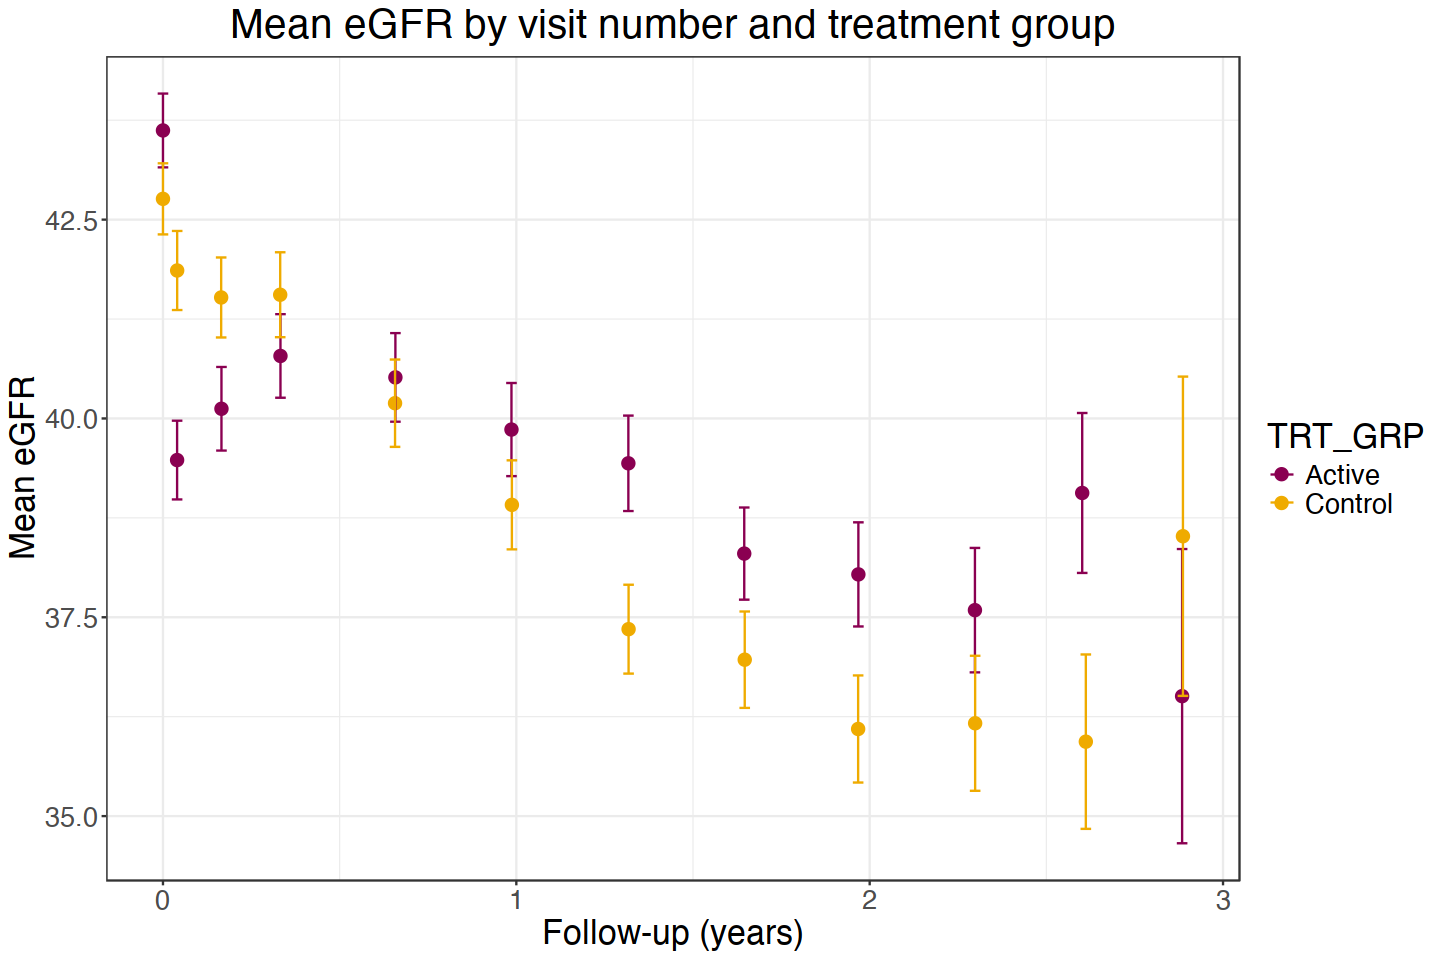

In [21]:
# ggplot mean AVAL by TRT_GRP and visit number
options(repr.plot.width = 12, repr.plot.height = 8) 
g <- ggplot(egfr_plot_df, aes(x=mean_yrs, y=mean_eGFR, color=TRT_GRP)) + 
    geom_point(size=3) + 
    geom_errorbar(aes(ymin=sterr_min, ymax=sterr_max), width=.03) +
    labs(title = 'Mean eGFR by visit number and treatment group', x = 'Visit number', y = 'Mean eGFR') + 
    theme_bw() + 
    theme(plot.title = element_text(hjust = 0.5))

# make the text larger
g <- g + theme(text = element_text(size=20, color = "black"))

# set color palette
# '#8A0051'
# '#EFAB00'
g <- g + scale_color_manual(values = c('#8A0051', '#EFAB00'))

# Set x axis title
g <- g + xlab('Follow-up (years)')
# Add sample size counts to the bottom of the plot
#g <- g + geom_text(data=egfr_plot_df, aes(x=mean_yrs, y=0, label=n), size=5)
g


## Kaplan Meier Survival Curve

In [57]:
head(cox_df)

,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,MAX_DAY,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days,DAY_Sustained >=50% decline in eGFR,DAY_Sustained >=57% decline in eGFR,DAY_Sustained >=40% decline in eGFR,DAY_Sustained eGFR<15 (mL/min/1.73 m2),DAY_Death (adj),DAY_Chronic dialysis (adj) >=90 days,MAX_FOLLOW_UP
,<int>,<int>,<int>,<ord>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,44,1,Active,30 to <45 ml/min/1.73 m2,721,0,0,0,0,0,0,721,721,721,721,721,721,721
2,2,1,31,3,Active,30 to <45 ml/min/1.73 m2,696,0,0,0,0,0,0,696,696,696,696,696,696,696
3,3,1,28,4,Active,<30 ml/min/1.73 m2,954,0,0,0,0,0,0,954,954,954,954,954,954,954
4,4,1,61,4,Active,>=60 ml/min/1.73 m2,884,0,0,0,0,0,0,884,884,884,884,884,884,884
5,5,1,37,4,Active,30 to <45 ml/min/1.73 m2,1008,0,0,0,0,0,0,1008,1008,1008,1008,1008,1008,1008
6,6,2,35,1,Control,30 to <45 ml/min/1.73 m2,923,0,0,0,0,0,0,923,923,923,923,923,923,923


In [64]:
table(ADET$PARAM)


  Chronic dialysis (adj) >=90 days                        Death (adj) 
                                49                                 90 
   Sustained >=40% decline in eGFR    Sustained >=50% decline in eGFR 
                               203                                117 
   Sustained >=57% decline in eGFR Sustained eGFR<15 (mL/min/1.73 m2) 
                                66                                 79 

In [27]:
library(survival)
library(survminer)

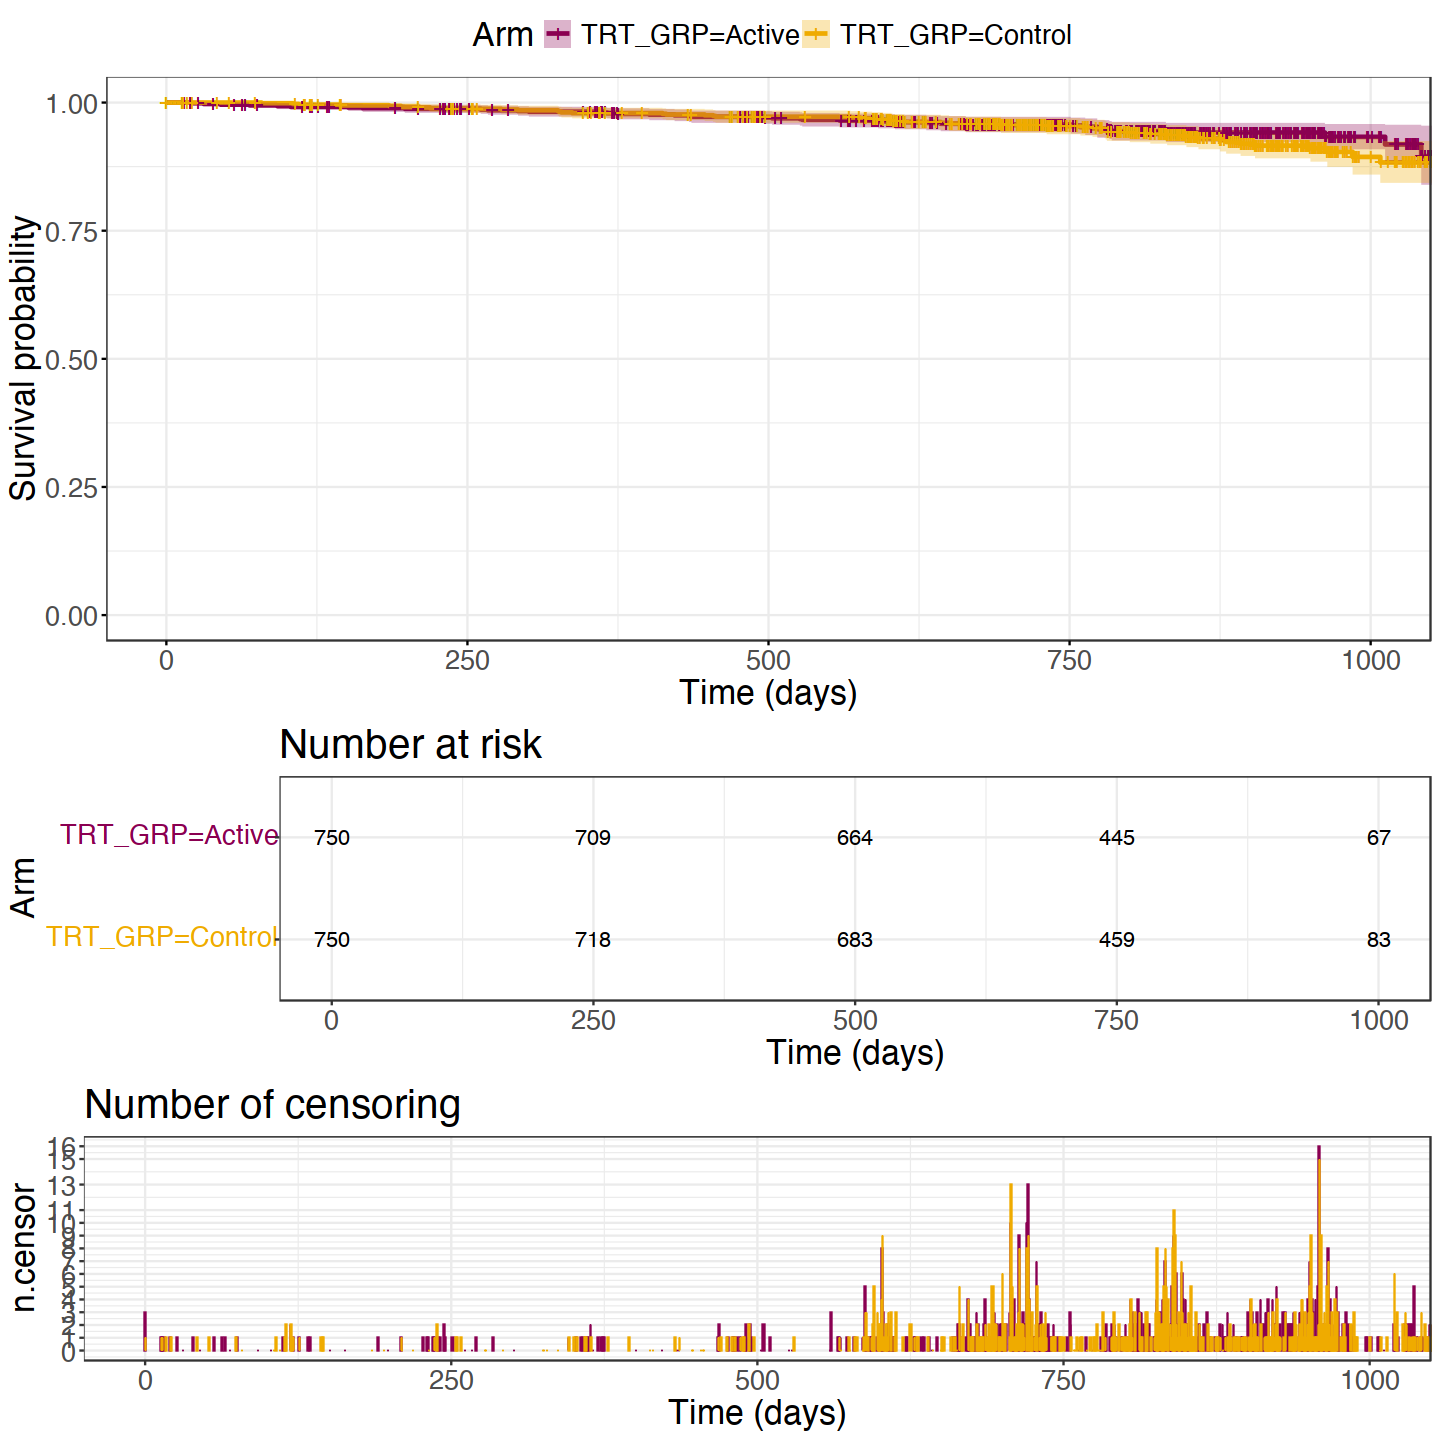

In [75]:
options(repr.plot.width = 12, repr.plot.height = 12) 
event_col = 'Death (adj)'
event_time_col = 'DAY_Death (adj)'
cox_model <- coxph(Surv(get(event_time_col), get(event_col)) ~ TRT_GRP + STRATAN + EGFRBL, data=cox_df)

# Fit the Kaplan-Meier Survival Curve
km_fit_group <- survfit(Surv(get(event_time_col), get(event_col)) ~ TRT_GRP, data = cox_df)

ggsurvplot(km_fit_group, 
           conf.int = TRUE, 
           pval = FALSE, 
           risk.table = TRUE, 
           legend.title = "Arm",
           palette = c("#8A0051", "#EFAB00"),
           xlab = "Time (days)",
           ncensor.plot = TRUE,
           ggtheme = theme_bw()+theme(text = element_text(size=20, color = "black")))
           

Warning message in .pvalue(fit, data = data, method = method, pval = pval, pval.coord = pval.coord, :
"There are no survival curves to be compared. 
 This is a null model."


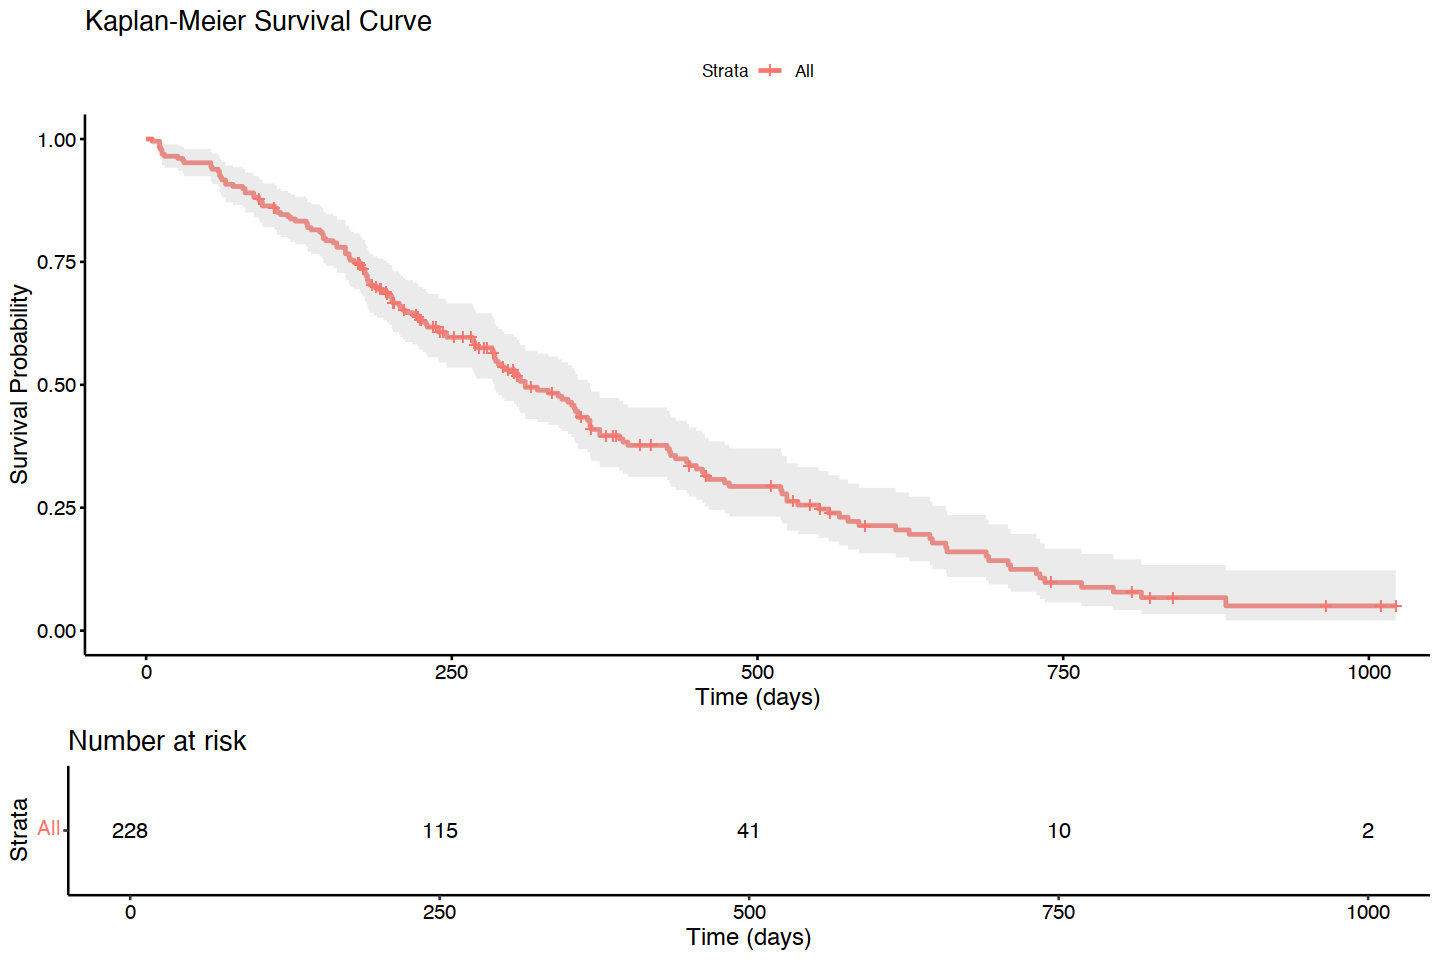

In [26]:
data(lung)  # Built-in dataset

# Create a Surv object (Survival Time and Event Status)
surv_object <- Surv(time = lung$time, event = lung$status)


# Fit the Kaplan-Meier Survival Curve
km_fit <- survfit(surv_object ~ 1, data = lung)

# Plot the Kaplan-Meier Curve
ggsurvplot(km_fit, 
           conf.int = TRUE,          # Show confidence interval
           pval = TRUE,              # Show p-value
           risk.table = TRUE,        # Show risk table
           xlab = "Time (days)", 
           ylab = "Survival Probability",
           title = "Kaplan-Meier Survival Curve")

In [22]:
# I like using the 'gt' package for making clean tables because of it's flexibility
# I played around with the table1 package as well (it's pretty great), but the html output 
# doesn't display well in a jupyter notebook (so gt it is)
gt_table = gt(fmt_tbl, rownames_to_stub=TRUE) %>%
    tab_stubhead(label = html("<b>Baseline Characteristics")) %>% 
    cols_label(
        'Active(n=750)' = html('<b>Active<br>(n=750)'),
        'Control(n=750)' = html('<b>Control<br>(n=750)'),
    ) %>% 
    tab_row_group(
        group = html('<b>CKD Risk'),
        rows = c(
            'Strata 1 - no. (%)',
            'Strata 2 - no. (%)',
            'Strata 3 - no. (%)',
            'Strata 4 - no. (%)'
        )
    ) %>% 
    tab_row_group(
        group = html('<b>eGFR categories — no. (%)'),
        rows = c(
            '>=60 ml/min/1.73 m2',
            '45 to <60 ml/min/1.73 m2',
            '30 to <45 ml/min/1.73 m2',
            '<30 ml/min/1.73 m2',
            '>median - no. (%)'
        )
    ) %>% 
    tab_row_group(
        group = html("<b>Estimated GFR"),
        rows = c(
            'Mean +- SD - ml/min/1.73 m2',
            'Median (interquartile range)'
        )
    ) %>% 
    tab_options(
        table.width = '100%',
    ) 

gt:::as.tags.gt_tbl(gt_table)

ERROR: Error in dplyr::group_vars(data): object 'fmt_tbl' not found


In [ ]:
head(ADSL)
head(ADLB)

# rename columns
baseline_df
colnames(ADSL)


,ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat
,<int>,<int>,<int>,<int>,<chr>,<chr>
1,1,1,44,1,Active,30 to <45 ml/min/1.73 m2
2,2,1,31,3,Active,30 to <45 ml/min/1.73 m2
3,3,1,28,4,Active,<30 ml/min/1.73 m2
4,4,1,61,4,Active,>=60 ml/min/1.73 m2
5,5,1,37,4,Active,30 to <45 ml/min/1.73 m2
6,6,2,35,1,Control,30 to <45 ml/min/1.73 m2


ID,TRTPN,AVAL,ADAY,AVISITN,PARAM,PARAMCD,PARAMN,DAYS_BETWEEN_VISITS
<int>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<int>,<dbl>
1,1,44,0,2,eGFR measurements,eGFR,7,NA
1,1,43,14,3,eGFR measurements,eGFR,7,14
1,1,41,56,4,eGFR measurements,eGFR,7,42
1,1,49,119,5,eGFR measurements,eGFR,7,63
1,1,41,238,6,eGFR measurements,eGFR,7,119
1,1,40,357,7,eGFR measurements,eGFR,7,119


ID,TRTPN,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,MAX_DAY
<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>
1,1,44,1,Active,30 to <45 ml/min/1.73 m2,721
2,1,31,3,Active,30 to <45 ml/min/1.73 m2,696
3,1,28,4,Active,<30 ml/min/1.73 m2,954
4,1,61,4,Active,>=60 ml/min/1.73 m2,884
5,1,37,4,Active,30 to <45 ml/min/1.73 m2,1008
6,2,35,1,Control,30 to <45 ml/min/1.73 m2,923
7,1,71,2,Active,>=60 ml/min/1.73 m2,1039
8,1,52,1,Active,45 to <60 ml/min/1.73 m2,850
9,2,41,2,Control,30 to <45 ml/min/1.73 m2,1080


[1] "ID"       "TRTPN"    "EGFRBL"   "STRATAN"  "TRT_GRP"  "eGFR_cat"

In [ ]:
# merge baseline features with event (ADET) data
merge_df <- left_join(ADSL, ADET, 
                by = c('ID'),
                suffix = c('', '_ADET'), 
                relationship = 'one-to-many') # validate that ADET rows uniquely map to a single ADSL row

# Identify patients that are not in the event data
# We assume that these patients were stable and did not experience any decline/event
stable_patient_ids = ADSL$ID[!ADSL$ID %in% ADET$ID]
head(cox_df)
dim(cox_df)

,ID,AVAL,PARAM,PARAMCD,PARAMN,TRTPN,TRTPN_BL,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,tmp_check_col
,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<lgl>
1,57,253,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,26,4,Active,<30 ml/min/1.73 m2,FALSE
2,72,602,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,24,2,Active,<30 ml/min/1.73 m2,FALSE
3,237,756,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,25,2,Active,<30 ml/min/1.73 m2,FALSE
4,269,389,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,36,2,Active,30 to <45 ml/min/1.73 m2,FALSE
5,284,646,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,33,2,Active,30 to <45 ml/min/1.73 m2,FALSE
6,285,722,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,36,1,Active,30 to <45 ml/min/1.73 m2,FALSE


[1] 49 12

In [ ]:
# merge baseline features with event (ADET) data
event_df <- left_join(ADET, ADSL, 
                by = c('ID'),
                suffix = c('', '_BL'), 
                relationship = 'many-to-one') # validate that ADET rows uniquely map to a single ADSL row
            
# Quick check to make sure treatment groups are consistent between dfs
table(event_df$TRTPN, event_df$TRTPN_BL)

# make sure we still have 1500 patienst (i.e. nobody just had baseline data)
length(unique(event_df$ID))

# Double check we haven't lost any observations
dim(event_df)[1] == dim(ADET)[1]

   
      1   2
  1 219   0
  2   0 385

[1] 290

[1] TRUE

In [ ]:
# Calculate the hazard ratio for median follow-up days
# subset to rows corresponding to the last event follow-up
event_max_df = event_df %>% 
                group_by(ID) %>% 
                filter(AVAL == max(AVAL))

median_followup_df = event_max_df %>% 
    group_by(TRT_GRP) %>% 
    summarize(
        n = n(),
        median = median(AVAL), 
        iqr25 = quantile(AVAL, 0.25),
        iqr75 = quantile(AVAL, 0.75)
    )

median_followup_df

TRT_GRP,n,median,iqr25,iqr75
<chr>,<int>,<dbl>,<dbl>,<dbl>
Active,127,664.0,468,753.5
Control,206,661.5,494,827.0


In [ ]:
unique(event_df$PARAM)

[1] "Sustained >=50% decline in eGFR"    "Sustained >=57% decline in eGFR"   
[3] "Sustained >=40% decline in eGFR"    "Sustained eGFR<15 (mL/min/1.73 m2)"
[5] "Death (adj)"                        "Chronic dialysis (adj) >=90 days"

In [ ]:
# eGFR decline/kidney decline is generally irreversible, 
# so if a patient hits the 57% decline threshold, they at some point also hit the 50% and 40% thresholds

# Check to see that all patients in the more severe disease categories are 
# also captured in the less severe categories
id_57 <- event_df %>% 
    filter(PARAM == 'Sustained >=57% decline in eGFR') %>% 
    select('ID')

id_50 <- event_df %>% 
    filter(PARAM == 'Sustained >=50% decline in eGFR') %>% 
    select('ID')

id_40 <- event_df %>% 
    filter(PARAM == 'Sustained >=40% decline in eGFR') %>% 
    select('ID')

id_egfr15 <- event_df %>% 
    filter(PARAM == 'Sustained eGFR<15 (mL/min/1.73 m2)') %>% 
    select('ID')

In [ ]:
# These should all be TRUE if we capture a patients full eGFR decline 
all(id_57$ID %in% id_40$ID)
all(id_57$ID %in% id_50$ID)
all(id_50$ID %in% id_40$ID)

# these should all be 1
print('---')
mean(id_57$ID %in% id_40$ID)
mean(id_57$ID %in% id_50$ID)
mean(id_50$ID %in% id_40$ID)

# egfr < 15 is end-stage liver failure (time for dialysis)
# it's possible that a person with a low baseline egfr could 
# hit <15 category before hitting the 40, 50, or 57% decline categories
print('---')
mean(id_egfr15$ID %in% id_40$ID)
mean(id_egfr15$ID %in% id_50$ID)
mean(id_egfr15$ID %in% id_57$ID)


[1] TRUE

[1] FALSE

[1] TRUE

[1] "---"


[1] 1

[1] 0.9848485

[1] 1

[1] "---"


[1] 1

[1] 0.9113924

[1] 0.6708861

In [ ]:
# looks like some patients that hit the 57% decline threshold are not capture in the 50% threshold bin
# let's see who they are

# oddball patient
id_57$ID[!id_57$ID %in% id_50$ID]

# Patient 198 is a bit funky since they should have hit the 40% decline threshold prior to the 57% 
# In a real dataset, this would trigger some minor data reconciliation. Since it's simualated data,
# we'll move forward and assume that they also hit the 50% decline threshold on day 721
event_df %>%
    filter(ID == 198) %>% 
    arrange(AVAL)


[1] 198

ID,AVAL,PARAM,PARAMCD,PARAMN,TRTPN,TRTPN_BL,EGFRBL,STRATAN,TRT_GRP,eGFR_cat
<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
198,721,Sustained >=57% decline in eGFR,EGFR57,4,2,2,25,4,Control,<30 ml/min/1.73 m2
198,722,Sustained >=40% decline in eGFR,EGFR40,6,2,2,25,4,Control,<30 ml/min/1.73 m2
198,722,Sustained eGFR<15 (mL/min/1.73 m2),EGFR15,3,2,2,25,4,Control,<30 ml/min/1.73 m2


In [ ]:
# egfr < 15 is end-stage liver failure (time to get on dialysis)
# it's possible that a person with a low baseline egfr could 
# hit <15 category before hitting the 40, 50, or 57% decline categories

# so these do not necessarily have to equal 1
mean(id_egfr15$ID %in% id_40$ID)
mean(id_egfr15$ID %in% id_50$ID)
mean(id_egfr15$ID %in% id_57$ID)

# Do patients that go straight to end stage have lower baseline eGFR?
check_ids <- id_egfr15$ID[!id_egfr15$ID %in% id_57$ID]
event_df$tmp_check_col <- event_df$ID %in% check_ids
event_df %>% 
    group_by(tmp_check_col) %>%
    select(c('ID', 'EGFRBL')) %>% 
    distinct() %>% 
    summarize(
        mean = mean(EGFRBL),
        max = max(EGFRBL),
        sd = sd(EGFRBL),
        iqr25 = quantile(EGFRBL, 0.25),
        iqr75 = quantile(EGFRBL, 0.75)
    )
# the answer is yes, patients that went straight to egfr < 15 cat (without hitting the 57% threshold) had a lower mean starting eGFR
# There are still some patients in the low starting eGFR group that should have triggered the 57% decline threshold (e.g. (40-15)/40 = 62.5% decline)
# But since this is simulated data, we'll just note this and move forward

[1] 1

[1] 0.9113924

[1] 0.6708861

Adding missing grouping variables: `tmp_check_col`


tmp_check_col,mean,max,sd,iqr25,iqr75
<lgl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
FALSE,39.34470,83,11.359596,30,46
TRUE,28.76923,40,4.283061,26,30


In [ ]:
Rates_A <- c(1.72, 1.74, 0.58, 1.5, 1)
Rates_P <- c(2.47, 2.24, 2.9, 4, 6)


dat <- simHCE(n = 2500, TTE_A = Rates_A, TTE_P = Rates_P, theta=1,
              CM_A = -3, CM_P = -6, CSD_A = 16, CSD_P = 15, fixedfy = 3)

head(dat)

,ID,TRTP,GROUP,GROUPN,AVALT,AVAL0,AVAL,seed,PADY
,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,A,C,6480,1080,-28.94,6506.88,1742671242,1080
2,2,A,C,6480,1080,14.72,6550.54,1742671242,1080
3,3,A,TTE2,2160,910,910.00,3070.00,1742671242,1080
4,4,A,C,6480,1080,3.94,6539.76,1742671242,1080
5,5,A,TTE4,4320,129,129.00,4449.00,1742671242,1080
6,6,A,C,6480,1080,-8.53,6527.29,1742671242,1080


In [ ]:
Rates_A <- 10
Rates_P <- 15
dat <- simHCE(n = 1000, n0 = 500, TTE_A = Rates_A, TTE_P = Rates_P, 
              CM_A = 0.1, CM_P = 0, seed = 5, shape = 0.2, logC = TRUE, dec = 0)
summaryWO(dat)

$summary
  TRTP    WIN   LOSS   TIE TOTAL        WR       WO
1    A 225353 226289 48358 5e+05 0.9958637 0.996263
2    P 226289 225353 48358 5e+05 1.0041535 1.003751

$summary_by_GROUP
  TRTP GROUP    WIN   LOSS   TIE  TOTAL
1    A     C 171624  52692 32184 256500
2    P     C 182721  52095 32184 267000
3    A  TTE1  53729 173597 16174 243500
4    P  TTE1  43568 173258 16174 233000

$WO
        WO         SE       WP      SE_WP
1 0.996263 0.06341366 0.499064 0.01585336

In [ ]:
# pivot PARAM to wide format so we know who did/didn't have an event
event_wide_df <- event_df %>% 
                    pivot_wider(
                        id_cols = c('ID'),
                        names_from = PARAM,
                        values_from = PARAM
                    )
head(event_wide_df)

convert_na_to_false <- function(x) {
  !is.na(x)
}

event_wide_df <- event_wide_df %>%
    mutate(across(unique(event_df$PARAM), convert_na_to_false))

head(event_wide_df)

event_df %>% left_join(ADSL, by = 'ID')

ID,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
11,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),NA,NA
15,NA,NA,NA,NA,Death (adj),NA
21,NA,NA,Sustained >=40% decline in eGFR,NA,NA,NA
39,NA,NA,Sustained >=40% decline in eGFR,NA,NA,NA
41,NA,NA,NA,NA,Death (adj),NA
46,Sustained >=50% decline in eGFR,NA,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),NA,NA


ID,Sustained >=50% decline in eGFR,Sustained >=57% decline in eGFR,Sustained >=40% decline in eGFR,Sustained eGFR<15 (mL/min/1.73 m2),Death (adj),Chronic dialysis (adj) >=90 days
<int>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
11,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE
15,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
21,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
39,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
41,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
46,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE


ID,AVAL,PARAM,PARAMCD,PARAMN,TRTPN.x,TRTPN_BL,EGFRBL.x,STRATAN.x,TRT_GRP.x,eGFR_cat.x,tmp_check_col,TRTPN.y,EGFRBL.y,STRATAN.y,TRT_GRP.y,eGFR_cat.y
<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<lgl>,<int>,<int>,<int>,<chr>,<chr>
11,359,Sustained >=50% decline in eGFR,EGFR50,5,2,2,44,3,Control,30 to <45 ml/min/1.73 m2,FALSE,2,44,3,Control,30 to <45 ml/min/1.73 m2
11,467,Sustained >=57% decline in eGFR,EGFR57,4,2,2,44,3,Control,30 to <45 ml/min/1.73 m2,FALSE,2,44,3,Control,30 to <45 ml/min/1.73 m2
11,359,Sustained >=40% decline in eGFR,EGFR40,6,2,2,44,3,Control,30 to <45 ml/min/1.73 m2,FALSE,2,44,3,Control,30 to <45 ml/min/1.73 m2
11,841,Sustained eGFR<15 (mL/min/1.73 m2),EGFR15,3,2,2,44,3,Control,30 to <45 ml/min/1.73 m2,FALSE,2,44,3,Control,30 to <45 ml/min/1.73 m2
15,962,Death (adj),DTHADJ,1,1,1,37,3,Active,30 to <45 ml/min/1.73 m2,FALSE,1,37,3,Active,30 to <45 ml/min/1.73 m2
21,737,Sustained >=40% decline in eGFR,EGFR40,6,1,1,41,3,Active,30 to <45 ml/min/1.73 m2,FALSE,1,41,3,Active,30 to <45 ml/min/1.73 m2
39,595,Sustained >=40% decline in eGFR,EGFR40,6,2,2,45,4,Control,45 to <60 ml/min/1.73 m2,FALSE,2,45,4,Control,45 to <60 ml/min/1.73 m2
41,325,Death (adj),DTHADJ,1,2,2,51,4,Control,45 to <60 ml/min/1.73 m2,FALSE,2,51,4,Control,45 to <60 ml/min/1.73 m2
46,957,Sustained eGFR<15 (mL/min/1.73 m2),EGFR15,3,2,2,29,2,Control,<30 ml/min/1.73 m2,TRUE,2,29,2,Control,<30 ml/min/1.73 m2


In [ ]:
# Fit the Cox proportional hazards model for each outcome
# Each outcome is not mutually exclusive (i.e. usually have declining egfr priot to death)
# We should employ a comprehensive model like a hierarchical composite endpoint 
# for the purposes of this exercise, we'll just fit a model for each outcome

for (event in unique(event_df$PARAM)){
    cox_df = event_df %>% filter(PARAM == event)
}
#cox_model <- coxph(Surv(time, status) ~ treatment + age, data = data)



In [ ]:
cox_df

ID,AVAL,PARAM,PARAMCD,PARAMN,TRTPN,TRTPN_BL,EGFRBL,STRATAN,TRT_GRP,eGFR_cat,tmp_check_col
<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<lgl>
57,253,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,26,4,Active,<30 ml/min/1.73 m2,FALSE
72,602,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,24,2,Active,<30 ml/min/1.73 m2,FALSE
237,756,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,25,2,Active,<30 ml/min/1.73 m2,FALSE
269,389,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,36,2,Active,30 to <45 ml/min/1.73 m2,FALSE
284,646,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,33,2,Active,30 to <45 ml/min/1.73 m2,FALSE
285,722,Chronic dialysis (adj) >=90 days,DIAL90,2,1,1,36,1,Active,30 to <45 ml/min/1.73 m2,FALSE
362,537,Chronic dialysis (adj) >=90 days,DIAL90,2,2,2,29,4,Control,<30 ml/min/1.73 m2,FALSE
373,574,Chronic dialysis (adj) >=90 days,DIAL90,2,2,2,33,2,Control,30 to <45 ml/min/1.73 m2,FALSE
388,680,Chronic dialysis (adj) >=90 days,DIAL90,2,2,2,29,4,Control,<30 ml/min/1.73 m2,FALSE


In [ ]:
paste0(summary_table$TRT_GRP, '\n(n=', summary_table$n, ')')

[1] "Active\n(n=750)"  "Control\n(n=750)"

In [ ]:
summary_table_t = data.frame(summary_table_t)
colnames(summary_table_t) = paste0(summary_table$TRT_GRP, '(n=', summary_table$n, ')')

head(summary_table_t)

,Active(n=750),Control(n=750)
,<chr>,<chr>
TRT_GRP,Active,Control
n,750,750
eGFR_bl_mean,43.62133,42.76133
eGFR_bl_sd,12.71063,12.24027
eGFR_bl_median,42,41
eGFR_bl_iqr,20,18


In [ ]:
gt_table = gt(summary_table_t, rownames_to_stub=TRUE) %>%
    tab_stubhead(label = "Baseline Characteristics") %>% 
    cols_label(
        'Active(n=750)' = html('Active<br>(n=750)'),
        'Control(n=750)' = html('Control<br>(n=750)'),
    ) %>% 
    tab_row_group(
        group = "eGFR",
        rows = c('n')
    )

gt:::as.tags.gt_tbl(gt_table)

Shiny tags cannot be represented in plain text (need html)